# How to Run this Notebook?

This notebook builds upon the notebook for Exercise 1: RAG with noReranker. The explanations that repeat from the previous notebook are greyed out in this notebook.

<font color="#d3d3d3">
1. Generate API key for OpenAI (ChatGPT): https://platform.openai.com/settings/organization/api-keys
Make sure to save the API key. You'll get to see the key only once at the time of generation. If you miss copying the key, you may need to generate a new key.<br>
2. Generate API token for HuggingFace Source: https://huggingface.co/settings/tokens/new?tokenType=write
Just like last time, make sure to save this API key as well.
</font>

3. Generate API key for Cohere: https://dashboard.cohere.com/api-keys
  Look out for `Create API Key` on the top right side of the settings on Cohere website.
5. Click on 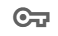 icon in the left menu bar of this Notebook

7. Click `+ Add new secret `
- <font color="#d3d3d3">Add OpenAI key, if not added already:
  * <font color="#d3d3d3">Under Name copy paste: `OPENAI_KEY`
  * Under Value copy paste: OpenAI key you saved earlier

- <font color="#d3d3d3">Add HuggingFace key, if not added already:
  * <font color="#d3d3d3">Under Name copy paste: `HF_KEY`
  * Under Value copy paste: HF key you saved earlier

- Add Cohere key:
  * Under Name copy paste: `COHERE_KEY`
  * Under Value copy paste: Cohere key you saved earlier

8. Enable access to the keys for this notebook by toggling the radio buttons in the `Secrets` section.
9. Close the `Secrets` section once done.
10. Click `Run all` under the `Runtime` in top menu to execute this notebook`


#Basic Setup
**Install Frameworks**

`langchain`, `langchain_core`, and `langchain_community` are components of the LangChain framework.

`faiss-cpu` is Facebook AI's similarity search library, optimized for CPU usage.

`openai==1.56.2` and `langchain_openai` are OpenAI's Python client library and LangChain's OpenAI integration package respectively.

`Cohere` and `langchain_Cohere` are Cohere's Python client library and LangChain's Cohere integration package respectively.

In [ ]:
%%capture
!pip install langchain langchain_core langchain_community faiss-cpu openai==1.56.2 langchain_openai cohere langchain_cohere

**Import Packages**



In [ ]:
import os
from google.colab import userdata
from typing import List, Dict, Any, Tuple
import requests
from langchain_core.documents import Document
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.prompts import PromptTemplate
from langchain_core.embeddings import Embeddings
from langchain_community.vectorstores import FAISS
from langchain_openai import ChatOpenAI
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
import numpy as np
import time
import json

from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank
from urllib.parse import urljoin

**Project's Secret Keys Setup**

<font color="#d3d3d3">
This code sets up authentication credentials by retrieving API keys from Colab's `Secrets` storage.
</font><br>
Cohere's API key is also retreieved from Colab's `Secrets` storage.

In [ ]:
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_KEY')
hfToken = userdata.get('HF_KEY')
os.environ["COHERE_API_KEY"] = userdata.get('COHERE_KEY')

# Configuration Dictionary
<font color="#d3d3d3">
Contains settings for document processing and RAG system, including parameters for text chunking, embedding generation, document retrieval, model specifications, prompts used and API endpoints.</font><br>
Default config settings for Cohere's Reranker were added.

In [ ]:
defaultConfig = {
    # Document processing settings
    "chunkSize": 500,
    "chunkOverlap": 50,
    "userAgentHeader": "YourCompany-ResearchBot/1.0 (your@email.com)",

    # Embedding settings
    "embeddingApiUrl": "https://api-inference.huggingface.co/models/BAAI/bge-base-en-v1.5",
    "embeddingDim": 768,

    #Defalt document
    "defaultDocument" : Document(
        page_content = "This is a default document.",
        metadata = {"source": "default"}
    ),

    # Vector store settings
    "numRetrievedDocuments": 12,

    # Document formatter settings
    "numSelectedDocuments": 5,

    #Reranker setting
    "rerankerModel": "rerank-english-v3.0",
    "numRerankedDocuments": 5,

    # Model settings
    "ragAnswerModel": "gpt-4o",
    "ragAnswerModelTemeprature": 0.7,

    # URLs to process
    "companyFilingUrls": [
        ("Tesla", "https://www.sec.gov/Archives/edgar/data/1318605/000162828024002390/tsla-20231231.htm")
    ],

    # RAG prompt template
    "ragPromptTemplate": """
    Give an answer for the `Question` using only the given `Context`. Use information relevant to the query from the entire context.
    Provide a detailed answer with thorough explanations, avoiding summaries.

    Question: {question}

    Context: {context}

    Answer:
    """
}


# Preprocessing Class
<font color="#d3d3d3">`FilingsPreProcessor` (Custom-defined class):
A custom class that downloads and preprocesses company filing documents from the web, splitting large filings into smaller text chunks for easier embedding and retrieval.<br>
`__init __`:
Constructor method that initializes the preprocessor with configuration parameters for chunk size, overlap, and an internal dictionary to store text chunks used specificially for extracting director names.<br>
`loadAndProcessFilings`:
Method that takes company filing URLs, downloads content, processes it into chunks, and stores the last 1000 characters for director names; returns processed documents and director name chunks.

- <font color="#d3d3d3">`Document` (Langchain class):
LangChain class representing a document with content and metadata, which is company name in this exercise.

- <font color="#d3d3d3">`WebBaseLoader` (Langchain class):
  * <font color="#d3d3d3">LangChain class that downloads content from the given 10-K company filing URLs with a custom User-Agent Header, which informs SEC website where the request is coming from and what kind of user agent it is. It's like introducing yourself when you enter a room, but for computer programs! This is often required for accessing web data, especially in responsible web scraping.

- <font color="#d3d3d3">`RecursiveCharacterTextSplitter` (Langchain class):
LangChain class that splits text documents into smaller chunks with specified size and overlap. It adds the company names as metadata for each chunk, then returns the processed chunks.
</font>

In [ ]:
class FilingsPreProcessor:
    def __init__(self, config: Dict[str, Any]):
        self.chunkSize = config["chunkSize"]
        self.chunkOverlap = config["chunkOverlap"]
        self.userAgentHeader = config["userAgentHeader"]

    # Using langchain class Document
    def loadAndProcessFilings(self, companyFilingUrls: List[Tuple[str, str]]) -> List[Document]:
        processedCompanyFilings = []

        for company, url in companyFilingUrls:
            try:
                # Using langchain class WebBaseLoader
                filingContent = WebBaseLoader(url, header_template = {'User-Agent': self.userAgentHeader}).load()

                # Using langchain class RecursiveCharacterTextSplitter
                splitFilingContent = RecursiveCharacterTextSplitter(
                    chunk_size = self.chunkSize,
                    chunk_overlap = self.chunkOverlap
                    ).transform_documents(filingContent)

                for split in splitFilingContent:
                    split.metadata.update({
                        'company': company,
                    })

                processedCompanyFilings.extend(splitFilingContent)

            except Exception as e:
                print(f"Error processing {url}: {str(e)}")
                continue

        return processedCompanyFilings

# Embedding class
<font color="#d3d3d3">`EmbeddingService` (Custom-defined class):
A custom class that inherits from LangChain's Embeddings class, providing text embedding functionality through an external API<br>
`__init __`:
Constructor that initializes the service with API URL, headers, and embedding configuration
- <font color="#d3d3d3">Sets up the Hugging Face embedding API endpoint an headers
- Stores an instruction prefix that is added to user's query before embedding generation.
- Sets the embedding dimension size as per `embeddingDim` value in `defaultConfig` (e.g., 768)

<font color="#d3d3d3">`embed_documents`:
From LangChain's interface - transforms a list of texts into embeddings by removing newlines and calling _generateEmbeddings

<font color="#d3d3d3">`embed_query`:
From LangChain's interface - transforms a single query text into an embedding by adding instruction prefix and removing newlines

<font color="#d3d3d3">`_generateEmbeddings`:
Internal helper method that:
- <font color="#d3d3d3">Splits the input texts into batches (default size 30)
- Sends each batch to the embedding API with _sendBatchRequest
- Handles retries and times out if requests take too long
- Ensures each embedding matches the expected dimension (e.g., 768)
- Returns a list of embeddings

<font color="#d3d3d3">`_sendBatchRequest`:
Internal helper method that makes POST requests to the embedding API and handles the response

In [ ]:
class EmbeddingService(Embeddings):               # Using langchain class Embeddings
    def __init__(self, config: Dict[str, Any]):
        self.api_url = config["embeddingApiUrl"]
        self.headers = {"Authorization": f"Bearer {hfToken}"}
        self.queryInstruction = "Represent this question for searching relevant passages: "
        self.embeddingDim = config["embeddingDim"]

    def embed_documents(self, texts: list[str]) -> List[List[float]]:
        textsToEmbed = [text.replace("\n", " ") for text in texts]
        return self._generateEmbeddings(textsToEmbed)

    def embed_query(self, text: str) -> List[float]:
        textToEmbed = self.queryInstruction + text.replace("\n", " ")
        return self._generateEmbeddings([textToEmbed])[0]

    def _generateEmbeddings(self, texts: List[str]) -> List[List[float]]:
        results = [np.zeros(self.embeddingDim).tolist() for _ in range(len(texts))]
        batchSize = 30
        longRetries = 0

        batches = [(i, texts[i:i + batchSize]) for i in range(0, len(texts), batchSize)]

        for Id, batch in batches:
            startTime = time.time()

            while time.time() - startTime < 30:
                try:
                    response = self._sendBatchRequest(batch)

                    if not isinstance(response, list):
                        continue

                    break
                except Exception as e:
                    time.sleep(1)
                    continue

            if time.time() - startTime > 10:
                longRetries += 1
                if longRetries > 3:
                    print("Too many long retries, stopping embedding generation")
                    return results

            for j, embedding in enumerate(response):
                if isinstance(embedding, list) and len(embedding) == self.embeddingDim:
                    results[Id + j] = embedding
                else:
                    print(f"Invalid embedding format at index {Id + j}: {embedding[:100]}...")

        if len(texts) > 1:
            successful = sum(1 for emb in results if any(emb))
            print(f"Successfully embedded {successful}/{len(texts)} texts")

        return results

    def _sendBatchRequest(self, batch: List[str]) -> List[List[float]]:
        response = requests.post(
            self.api_url,
            headers = self.headers,
            json = {"inputs": batch}
        )
        if response.status_code != 200:
            raise ValueError(f"API returned status code {response.status_code}")
        return response.json()

# Vector DB class
<font color="#d3d3d3">`VectorStore` (Custom Class):
This custom class manages a FAISS-based vector store for storing and retrieving them by cosine similarity.

<font color="#d3d3d3">`__init __`:
Constructor that initializes a FAISS vector store with a default document and configures a retriever with number of documents to retrieve.
- <font color="#d3d3d3">`FAISS` (Langchain class):
A LangChain wrapper class for Facebook AI Similarity Search library. It manages vector database creation, indexes embeddings and retrieves embeddings similar to the queried embedding. Its `from_documents` function accepts a chunk/query, and an instance of `Embedding` Langchain class for generating embeddings for provided chunk/query.
- The VectorStore class creates a retriever using self.store.as_retriever(). This retriever is responsible for fetching relevant documents from the vector store based on a query's embedding.

<font color="#d3d3d3">`addDocuments`:
It adds new documents to the FAISS vector store created in `__init__`, accepting a list of Document objects as input
- <font color="#d3d3d3">`Document` (Langchain class):
 A LangChain document class is used to represent each chunk as a `Document` object.



In [ ]:
class VectorStore:
    def __init__(self, config, embeddingFunction):
        # Using langchain class FAISS
        self.store = FAISS.from_documents([config["defaultDocument"]], embeddingFunction)
        self.retriever = self.store.as_retriever(
            search_kwargs = {"k": config["numRetrievedDocuments"]}
        )

    def addDocuments(self,  documents: List[Document]) -> None:
        self.store.add_documents(documents)

# Reranker Function
 It enhances the quality of search results by re-ranking them using Cohere's reranking capabilities within the LangChain framework.

`createReranker`:
The first parameter in this function is the name of Cohere's Model that we want to use and the default model name is obtained from `config`. `numRerankedDocuments` defines number of top-ranked chunks to keep after reranking.

- `CohereRerank` (Langchain class):
LangChain class specifically for reranking chunks using Cohere's reranking API. It reorders chunks based on their relevance to a query using Cohere's model

- `ContextualCompressionRetriever` (Langchain class):
It sets the previously created CohereRerank instance, `compressor`, as `base_compressor`. It also requires a `base_retriever` which is the retriever object retruned from vector database retrieval.

In [ ]:
def createReranker(config, baseRetriever):
    # Using langchain class CohereRerank
    compressor = CohereRerank(model=config["rerankerModel"], top_n = config["numRerankedDocuments"])

    # Using langchain class ContextualCompressionRetriever
    return ContextualCompressionRetriever(
        base_compressor = compressor, base_retriever = baseRetriever
    )

# RAG chain class
<font color="#d3d3d3">`RAGChain` (Custom-defined class):
 A custom class implementing a Retrieval-Augmented Generation (RAG) system that combines document retrieval with language model generation by retrieving the most relevant documents and using them to generate and answer.

<font color="#d3d3d3">`__init __`:
Initializes the RAG chain with configuration and a vector store retriever

- <font color="#d3d3d3">Stores a reference to the `baseRetriever` (from the VectorStore class)
- `ChatOpenAI` (Langchain class):
 LangChain class for interfacing with OpenAI's chat models
- prompt is an instance of `PromptTemplate` (a LangChain class) to build the RAG prompt.
- Sets the number of documents to be selected from the vector store</font>
- `retrieverWithReranking`: It makes the reranking retriever available for use within the RAGChain instance.
- <font color="#d3d3d3">Builds the entire chain pipeline via `_makeChain()`

<font color="#d3d3d3">Q) Why did we use Langchain's `PromptTemplate` class instead of a string template directly?
- <font color="#d3d3d3">It ensures dynamic input substitution with validation, reducing the risk of formatting errors or missing placeholders.
- It integrates seamlessly with LangChain's modular components, enhancing composability in workflows and simplifying maintenance.

<font color="#d3d3d3">`query`:
The main interface method that processes a question through the entire RAG pipeline and returns the LLM-generated answer.

`_retrieveContext`:
- if fReranker is false, it retrieves relevant chunks for a given question using the base retriever from `VectorStore` class
- else, it retrieves reranked relevant chunks for a given question using the retriever with reranking from `CohereRerank` class
- Uses `_formatDocs` to format (reranked) retrieved chunks into a string that can be used as context for the language model. <font color="#d3d3d3">`_formatDocs` does the following:
  * <font color="#d3d3d3">Selects only the first `self.numSelectedDocuments` chunks retrieved from vector store.
  *  `_getPrefix(doc)` extracts the company name added as metadata to each chunk in `loadAndProcessFilings`, and concatenates it to the text content of each chunk (`doc.page_content`).
  * Joins all the chunks into a single string.  It adds 2 line breaks `\n\n` as a seperator between two chunks.

<font color="#d3d3d3">`_makeChain`:
Constructs the processing pipeline using LangChain's Runnable interface components.

- <font color="#d3d3d3">`RunnableLambda` is a LangChain utility that wraps a callable Python function (in this case, _retrieveContext) and makes it compatible with LangChain pipelines. The output of this step is the retrieved chunks combined into a string generated by `retrieveContext`.
- `RunnablePassthrough` is a LangChain utility that simply passes the user's question to the next step in the pipeline without modifying it. This is useful when you need to include the question alongside the context in a prompt for generating response.
- Next step in pipeline replaces placeholder variables {context} and {question} in prompt instance with the retrieved context from `RunnableLambda` and the original question from `RunnablePassthrough`.
- `ChatOpenAI` is a LangChain interface for interacting with OpenAI's chat models. This component invokes the OpenAI language model (e.g., GPT-4) to generate a response based on the prompt.
- `StrOutputParser` is a LangChain utility that parses the raw output of the LLM (such as the model used via ChatOpenAI) into a clean string format.

In [ ]:
class RAGChain:
    def __init__(self, config: Dict[str, Any], baseRetriever: VectorStore, fReranker = False):
        self.config = config
        self.baseRetriever = baseRetriever
        self.llm = ChatOpenAI(model=config["ragAnswerModel"], temperature=config["ragAnswerModelTemeprature"])
        self.prompt = PromptTemplate.from_template(config["ragPromptTemplate"])
        self.numSelectedDocuments = config["numSelectedDocuments"]
        self.fReranker = fReranker
        if self.fReranker:
                self.retrieverWithReranking = createReranker(self.config, self.baseRetriever)

    def _retrieveContext(self, question: str) -> str:
        if self.fReranker:
            rerankedDocs = self.retrieverWithReranking.invoke(question)
            return self._formatDocs(rerankedDocs)
        else:
            retrievedDocs = self.baseRetriever.invoke(question)
            return self._formatDocs(retrievedDocs)

    def _formatDocs(self, docs: List[Document]) -> str:
        def _getPrefix(doc):
            company = doc.__dict__.get('metadata', {}).get('company', '')
            return company

        return "\n\n".join(f"{_getPrefix(doc)}\n{doc.page_content}" for doc in docs[:self.numSelectedDocuments])

    def _makeChain(self):
        return (
            {
                "context": RunnableLambda(self._retrieveContext),
                "question": RunnablePassthrough()
            }
            | self.prompt
            | self.llm
            | StrOutputParser()
        )

    def query(self, question: str) -> str:
        return self._makeChain().invoke(question)

# PreProcessing Data

<font color="#d3d3d3">So far, we have defined the classes (blueprint) needed for implementing a simple RAG prototype on 10-K filings. These classes provide the foundational structure for tasks like data retrieval and processing. Next, we will create instances to operationalize these tasks and demonstrate preprocessing functionality.

In [ ]:
config = defaultConfig.copy() # Creates a separate copy of the default configuration dictionary (defaultConfig) so that any subsequent changes won't alter the original default settings.

## Chunking
* <font color="#d3d3d3">Creates a `FilingsPreProcessor` instance, responsible for downloading webpages and splitting filings into smaller, more manageable chunks.
* Uses the `loadAndProcessFilings` to load, split, and process the filing URLs listed in config["companyFilingUrls"].
* Returns chunks ready for indexing in Vector DB.


In [ ]:
preProcessorObj = FilingsPreProcessor(config)
processedFilings = preProcessorObj.loadAndProcessFilings(config["companyFilingUrls"])

## Embedding and Vector Storage
- <font color="#d3d3d3">Instantiates an `EmbeddingService` object, which provides text embedding functionality (via the Hugging Face Inference API in this example).
- Instantiates a `VectorStore` object
- Builds a VectorStore object that internally uses a FAISS store to index and retrieve documents based on vector similarity.
- Uses embedding object created earlier to generate embeddings of chunks added by `addDocuments`.


In [ ]:
embeddingServiceObj = EmbeddingService(config)
vectorStoreObj = VectorStore(config, embeddingServiceObj)
vectorStoreObj.addDocuments(processedFilings)

Successfully embedded 942/942 texts


# User Query Processing

## RAG Chain pipeline
<font color="#d3d3d3">This pipeline assembles all the necessary pieces:
- <font color="#d3d3d3">Takes the configuration settings (`config`).
- Connects the RAG pipeline to the vector store through the retriever (`vectorStoreObj.retriever`) and fetches the most relevant chunks based on the user query passed to `ragObj.query`.
- Packages the entire pipeline into a single object (`ragObj`) that represents your complete RAG system. `ragObj` is an instance of the `RAGChain`class. You can think of it like a container or a handle that is used to interact with the entire RAG system.</font>
- Since the `fReranker` value is not defined, its default value of `false` will be used in the `RAGChain`. This means the retrieved chunks will not be processed through the Reranker.

In [ ]:
ragObj = RAGChain(config, vectorStoreObj.retriever)

The only change from the last statement is that `fReranker` value is passed as `true`. This means the retrieved chunks will be processed through the Reranker.

In [ ]:
rerankerRagObj = RAGChain(config, vectorStoreObj.retriever, True)

## Pass User Query
This is where you pass the user's query to RAG pipeline.

Note: The spelling mistakes in the query are intentional. We use only one 10-K document to ensure that the code runs within a reasonable time in the free Colab version, thereby reducing preprocessing time. The retrieval performs well even without the Reranker for many queries due to the smaller number of chunks. Therefore, to demonstrate the value of the Reranker, we identified a query that consistently underperforms without reranker.

In real-world scenarios, datasets are much larger and cosine based similarity often make mistakes in ranking chunks. Hence, a base retriever alone is typically insufficient without a Reranker.

In [ ]:
print(ragObj.query("List the majour changes that occoured in the company in 2023"))

In 2023, Tesla experienced several major changes across various aspects of its operations:

1. **Data Security Incident**: In the second quarter of 2023, Tesla faced a significant data security incident where a foreign news outlet reported obtaining misappropriated data, which included purportedly non-public Tesla business and personal information. This event necessitated notifications to potentially affected parties and highlighted ongoing challenges in protecting sensitive company data.

2. **Financial and Operational Changes**: Tesla's selling, general, and administrative (SG&A) expenses saw a notable increase by $854 million, or 22%, compared to the previous year. This increase was primarily driven by a $447 million rise in employee and labor costs due to an increase in headcount, including professional services, and a $363 million increase in facilities-related expenses. These financial shifts indicate growth and expansion in Tesla's operations, necessitating more resources and in

## Final Response Analysis
The final response lists the following advancments:


1.  Development of a new proprietary lithium-ion battery cell
2.  Improved manufacturing processes for the batteries.

The response explains these developments and how they impact Tesla.

You can see how RAG is able to answer basic queries that by retrieving the information required.

In [ ]:
print(rerankerRagObj.query("List the majour changes that occoured in the company in 2023"))

In 2023, Tesla experienced several major changes across various aspects of its operations and financial management:

1. **Rule 10b5-1 Trading Arrangement**: In October 2023, Robyn Denholm, a director at Tesla, adopted a Rule 10b5-1 trading arrangement. This arrangement would potentially allow for the sale of up to 281,116 shares of Tesla's common stock, contingent on certain conditions. This type of arrangement is typically used to mitigate insider trading risks by allowing insiders to set up a predetermined plan for selling stocks.

2. **Increased SG&A Expenses**: Tesla’s Selling, General, and Administrative (SG&A) expenses increased significantly by $854 million, or 22%, in 2023 compared to 2022. This increase was largely due to a $447 million rise in employee and labor costs, stemming from increased headcount, including professional services, and a $363 million increase in facilities-related expenses. These changes suggest a strategic investment in personnel and infrastructure to su

Without the Reranker, the RAG system failed to retrieve information about a Tesla director, Robyn Denholm, planning to sell up to 281,116 shares of the company's common stock. Many would argue that such a development represents a significant event for Tesla in 2023.